# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [ ]:
#
# Add your code here
#
# A: Only run this in Google Colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

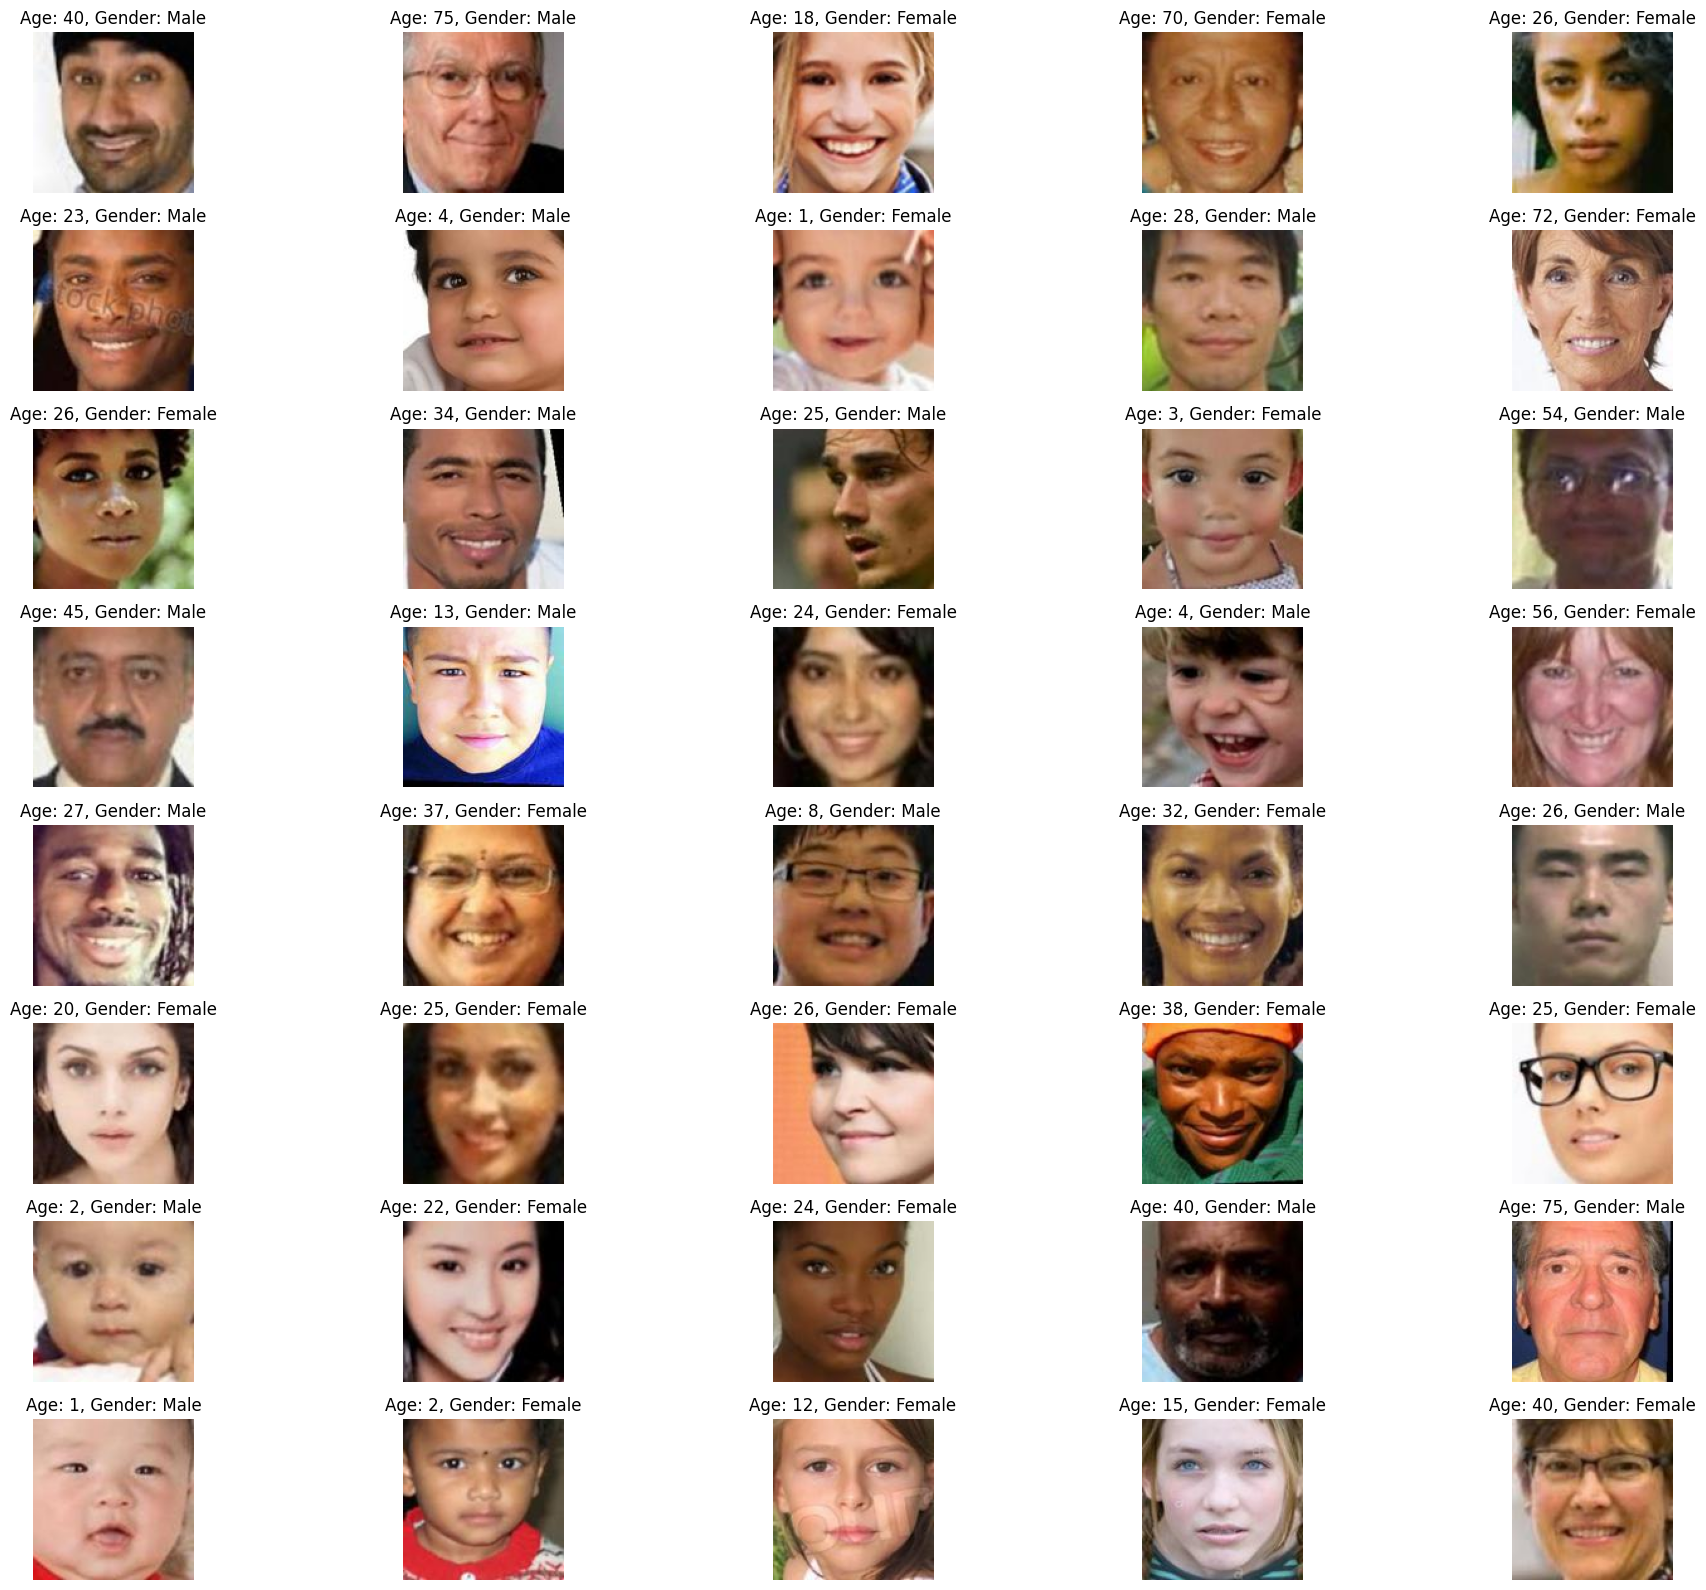

In [ ]:
#
# Add your code here
#
# A: Download data and put in root level with folder name 'train_val'
import matplotlib.pyplot as plt
import os

# Define the directory where images are stored
image_dir = '/content/drive/MyDrive/train_val/'

# List all files in the directory
files = os.listdir(image_dir)

# Filter out 20 images for visualization
selected_files = files[:40]

# Set up the plot
fig, axes = plt.subplots(8, 5, figsize=(20, 16))
axes = axes.ravel()

for i, file_name in enumerate(selected_files):
    # Extract age and gender from the file name
    age, gender, _, _ = file_name.split('_')
    gender = 'Male' if gender == '0' else 'Female'

    # Load and display the image
    img = plt.imread(os.path.join(image_dir, file_name))
    axes[i].imshow(img)
    axes[i].set_title(f'Age: {age}, Gender: {gender}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
#
# Add your code here
#
# A: Split data into train, validation, and test sets
#        [] Need to remove test set to but adding to evaluate
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize lists to store ages, genders, and image file paths
ages = []
genders = []
image_paths = []

# Loop through each file in the selected files to extract age, gender, and file path
for file_name in files:
    # Skip system files like .DS_Store
    if file_name.startswith('.'):
        continue
    # Split the file name and check if it has the expected number of parts
    parts = file_name.split('_')
    if len(parts) >= 3:  # Ensure there are at least 3 parts (age, gender, and others)
        age, gender = parts[0], parts[1]
        # Validate age and gender to be numeric
        if age.isdigit() and gender.isdigit():
            ages.append(int(age))
            genders.append(int(gender))
            image_paths.append(os.path.join(image_dir, file_name))
        else:
            print(f"Skipping file {file_name} due to invalid age or gender value.")
    else:
        print(f"Skipping file {file_name} due to unexpected format.")


# Convert lists to numpy arrays for easier manipulation
ages = np.array(ages)
genders = np.array(genders)
image_paths = np.array(image_paths)

X_temp, X_test, y_temp_age, y_test_age, y_temp_gender, y_test_gender = train_test_split(
    image_paths, ages, genders, test_size=0.1, random_state=42)  # Adjust test_size as needed

# Now, split the combined training + validation set into separate training and validation sets
X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(
    X_temp, y_temp_age, y_temp_gender, test_size=0.22, random_state=42)  # Adjust test_size to get the desired validation size

# Save the split data for later use
np.savez('train_val_test_split.npz', X_train=X_train, X_val=X_val, X_test=X_test, y_train_age=y_train_age, y_val_age=y_val_age, y_test_age=y_test_age, y_train_gender=y_train_gender, y_val_gender=y_val_gender, y_test_gender=y_test_gender)

### Visualing
- Below I added a few cells to visualise a bit the dataset but this was more to get to know the data than anything else

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dataset_folder_name = '/content/drive/MyDrive/train_val/'
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 128
dataset_dict = {
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It iterates over all images and returns a DataFrame with
    the data (age, gender, and file path) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender = filename.split('_')[:2]  # Only extract age and gender, ignore other info
            return int(age), dataset_dict['gender_id'][int(gender)], path
        except Exception as ex:
            return None, None, None

    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        age, gender, file_path = parse_info_from_file(file)
        if age is not None and gender is not None:
            records.append((age, gender, file_path))

    df = pd.DataFrame(records, columns=['age', 'gender', 'file'])
    return df

df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,file
0,40,male,/content/drive/MyDrive/train_val/40_0_3_201701...
1,75,male,/content/drive/MyDrive/train_val/75_0_0_201701...
2,18,female,/content/drive/MyDrive/train_val/18_1_0_201701...
3,70,female,/content/drive/MyDrive/train_val/70_1_3_201701...
4,26,female,/content/drive/MyDrive/train_val/26_1_1_201701...


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
import numpy as np
from keras.utils import to_categorical
from PIL import Image
import pandas as pd

# Assuming dataset_dict, TRAIN_TEST_SPLIT, IM_WIDTH, IM_HEIGHT are defined elsewhere

class UtkFaceDataGenerator():
    def __init__(self, df):
        self.df = df

    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]


        # Map gender to gender_id for later use
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.max_age = self.df['age'].max()

        return train_idx, valid_idx, test_idx

    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        return im

    def generate_images(self, image_idx, is_training, batch_size=16):
        images, ages, genders = [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]

                age = person['age']
                gender = person['gender_id']  # No need to one-hot encode
                file = person['file']

                im = self.preprocess_image(file)

                ages.append(age)  # Keep age as original, without normalization
                genders.append(gender)  # Directly use the binary gender label
                images.append(im)

                if len(images) >= batch_size:
                    yield np.array(images), {'age_output': np.array(ages), 'gender_output': np.array(genders)}
                    images, ages, genders = [], [], []

            if not is_training:
                break

# Assuming df is your DataFrame containing the dataset
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

# Verification step
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=32)

#F: new stuff to fix validation stuff
valid_gen = data_generator.generate_images(valid_idx, is_training=False, batch_size=32)

from itertools import cycle
valid_gen = cycle(valid_gen)




In [ ]:
# A : Verify the data generator
# Fetch a single batch
inputs, outputs = next(train_gen)

# Inspect the batch
print(f"Input batch shape: {inputs.shape}")
print(f"Output keys: {outputs.keys()}")
print(f"Age targets shape: {outputs['age_output'].shape}")
print(f"Gender targets shape: {outputs['gender_output'].shape}")
# To verify the age ranges and pixel range of the generators, we can add a few lines of code to print these details.
# This will be done after fetching a single batch from the train generator.

# Calculate and print age range
age_range = (outputs['age_output'].min(), outputs['age_output'].max())
print(f"Age range in batch: {age_range}")

# Calculate and print pixel range
pixel_range = (inputs.min(), inputs.max())
print(f"Pixel range in batch: {pixel_range}")

Input batch shape: (32, 128, 128, 3)
Output keys: dict_keys(['age_output', 'gender_output'])
Age targets shape: (32,)
Gender targets shape: (32,)
Age range in batch: (1, 76)
Pixel range in batch: (0.0, 1.0)


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['batch_normalization[0][0

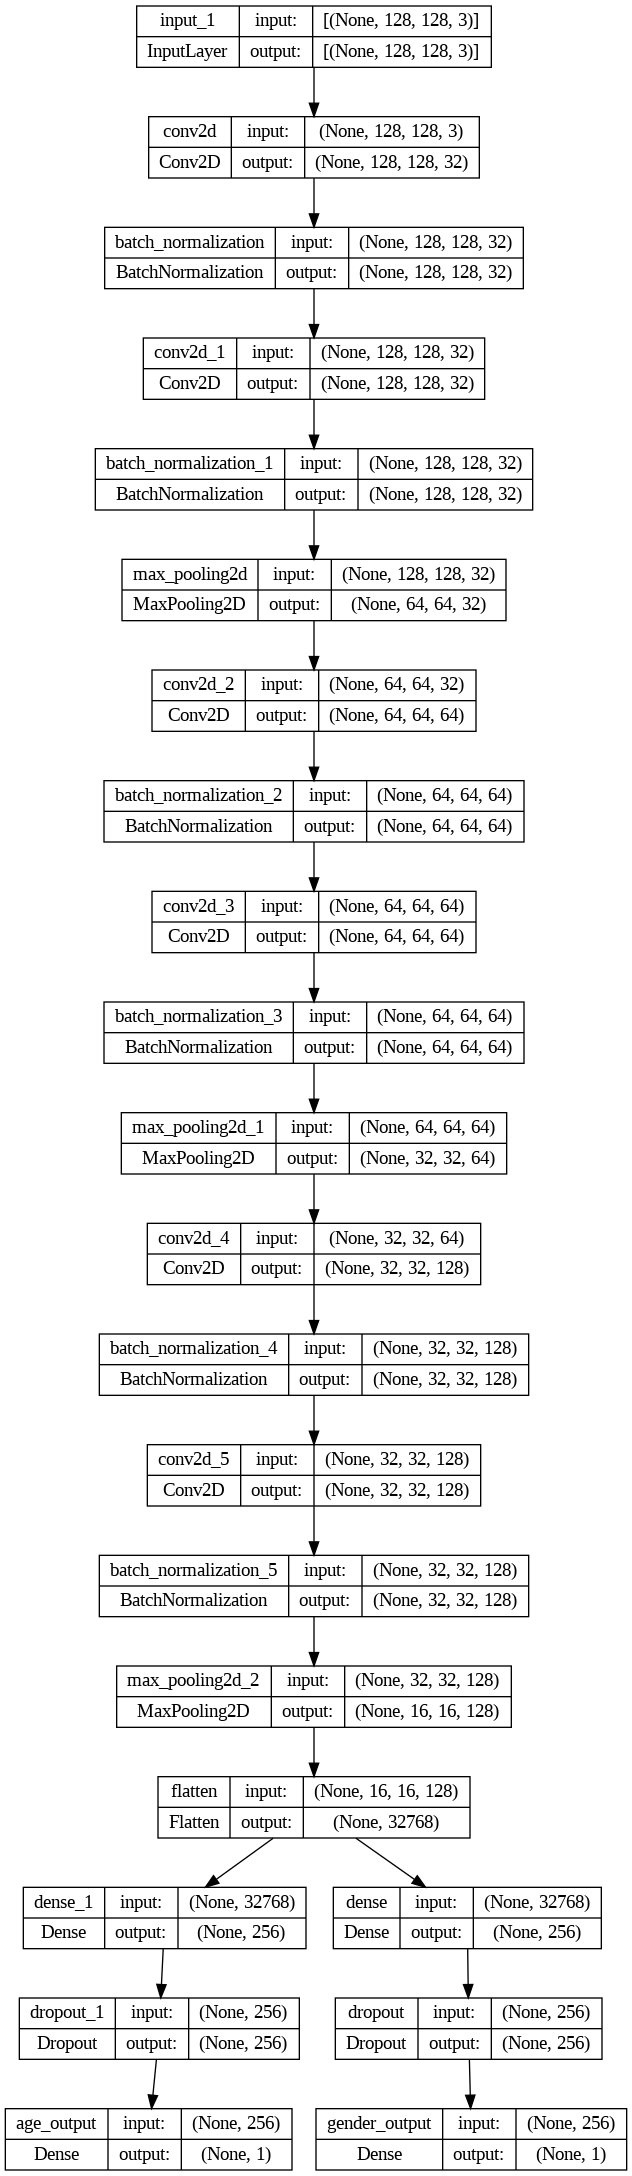

In [ ]:
#
# Add your code here
#

#F: did some tweaking, hard to tell if it actually does much

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define input layer
input_layer = Input(shape=(128, 128, 3))

# Convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
pool1 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
pool2 = MaxPooling2D((2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv5 = BatchNormalization()(conv5)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
pool3 = MaxPooling2D((2, 2))(conv6)


# Flatten layer
flatten = Flatten()(pool3)

# Dense layers for gender classification
# --Dropout layers used to reduce overfitting
dense_gender = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten)
dropout_gender = Dropout(0.5)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

#Dense layers for age prediction
dense_age = Dense(256,activation='relu', kernel_regularizer=l2(0.01))(flatten)
dropout_age = Dropout(0.5)(dense_age)
output_age = Dense(1, name='age_output')(dropout_age)

# Model stuff
modelA = Model(inputs=input_layer, outputs=[output_age, output_gender])


modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)


## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by

`modelA = load_model(model_folder+"age_gender_A.h5")`.


In [ ]:
#
# Add your code here
#
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


from keras.callbacks import ModelCheckpoint

modelA.compile(optimizer=Adam(learning_rate=5e-4),
               loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
               metrics={'age_output': ['mae'], 'gender_output': ['accuracy']})

#modelA.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

#fixed

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

history = modelA.fit(train_gen,
                     steps_per_epoch=len(train_idx) // 32,  # Number of batches per epoch
                     epochs=512,
                     validation_data=valid_gen,
                     validation_steps=len(test_idx)//32,
                     callbacks=[reduce_lr, early_stop])  # Number of batches in the validation set

modelA.save('./'+"age_gender_A.h5")

Epoch 1/512
76/76 [==============================] - 26s 191ms/step - loss: 383.9402 - age_output_loss: 372.8694 - gender_output_loss: 1.4058 - age_output_mae: 14.7606 - gender_output_accuracy: 0.6632 - val_loss: 532.0223 - val_age_output_loss: 522.0396 - val_gender_output_loss: 1.1163 - val_age_output_mae: 17.2102 - val_gender_output_accuracy: 0.4980 - lr: 5.0000e-04
Epoch 2/512
76/76 [==============================] - 11s 146ms/step - loss: 227.9833 - age_output_loss: 219.1910 - gender_output_loss: 0.5359 - age_output_mae: 11.3565 - gender_output_accuracy: 0.7558 - val_loss: 475.8563 - val_age_output_loss: 464.7242 - val_gender_output_loss: 3.4046 - val_age_output_mae: 15.8791 - val_gender_output_accuracy: 0.4980 - lr: 5.0000e-04
Epoch 3/512
76/76 [==============================] - 10s 133ms/step - loss: 198.4676 - age_output_loss: 190.6246 - gender_output_loss: 0.4555 - age_output_mae: 10.6832 - gender_output_accuracy: 0.7866 - val_loss: 415.3055 - val_age_output_loss: 406.7947 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


0.8865489363670349
7.290684700012207


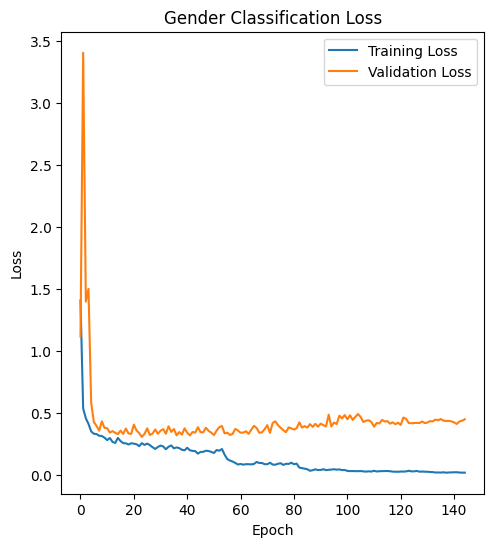

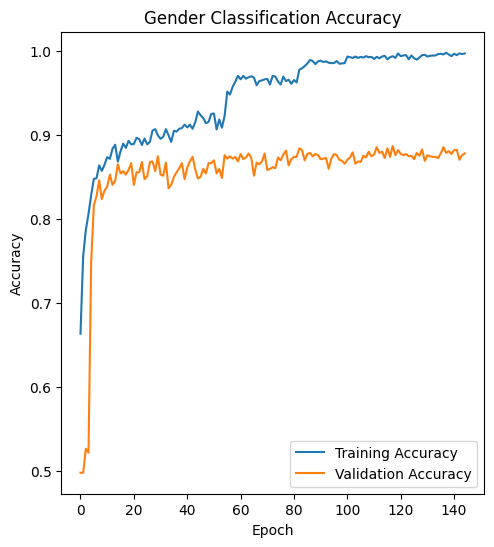

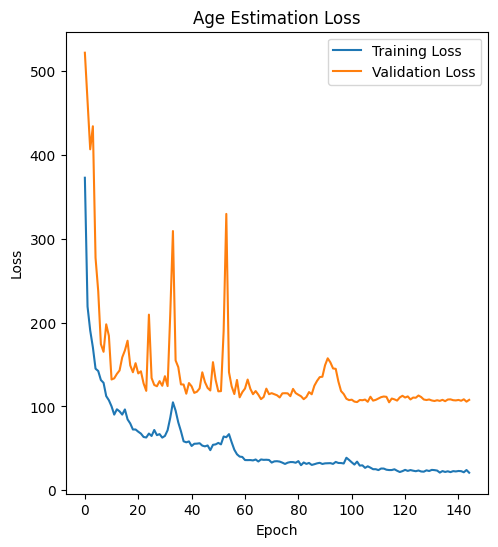

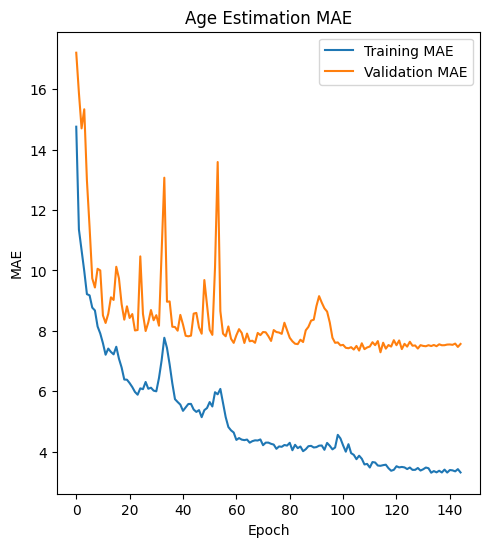

In [ ]:
#
# Add your code here
#

# F:
# Broken ATM, some problem with the validation stuff
# Fixed yay
import matplotlib.pyplot as plt

#Loss and accuracy for gender
gender_loss = history.history['gender_output_loss']
val_gender_loss = history.history['val_gender_output_loss']
gender_acc = history.history['gender_output_accuracy']
val_gender_acc = history.history['val_gender_output_accuracy']

print(max(val_gender_acc))


#Loss and MAE for age
age_loss = history.history['age_output_loss']
val_age_loss = history.history['val_age_output_loss']
age_mae = history.history['age_output_mae']
val_age_mae = history.history['val_age_output_mae']

print(min(val_age_mae))

#Plot loss for gender
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gender_loss, label='Training Loss')
plt.plot(val_gender_loss, label='Validation Loss')
plt.title('Gender Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot accuracy for
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(gender_acc, label='Training Accuracy')
plt.plot(val_gender_acc, label='Validation Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot loss for age
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(age_loss, label='Training Loss')
plt.plot(val_age_loss, label='Validation Loss')
plt.title('Age Estimation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE for age
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(age_mae, label='Training MAE')
plt.plot(val_age_mae, label='Validation MAE')
plt.title('Age Estimation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#squiggles :D


## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


9406464/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

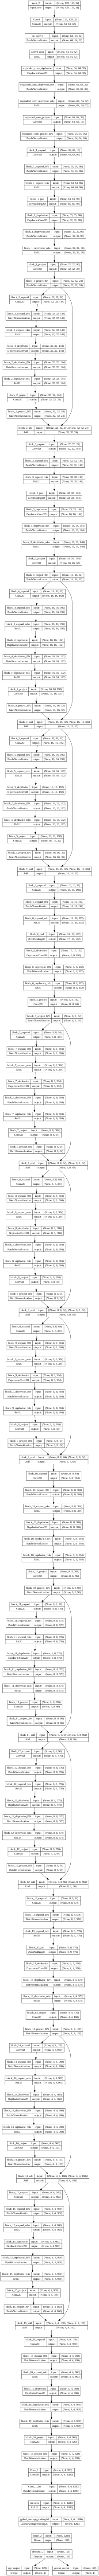

In [ ]:
#
# Add your code here
#

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained MobileNetV2 model, excluding its top (final) layer since we'll add our own
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model to prevent them from being updated during the first few training epochs
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for gender classification: binary classification
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Output layer for age estimation: regression
age_output = Dense(1, name='age_output')(x)

# Define the new model
modelB = Model(inputs=base_model.input, outputs=[age_output, gender_output])


modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True, dpi=32)


## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
#
# Add your code here
#
modelB.compile(optimizer=Adam(learning_rate=0.0001),
               loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
               metrics={'age_output': ['mae'], 'gender_output': ['accuracy']},
               loss_weights={'age_output': 1.0, 'gender_output': 1.0})

# Train the model
history = modelB.fit(
    train_gen,
    steps_per_epoch=len(train_idx) // 32,  # Running batch size of 32 for training
    epochs=128,  # Adjust the number of epochs to tinker around with the model
    validation_data=valid_gen,
    validation_steps=len(valid_idx) // 32,  # Running batch size of 32 for validation
)


modelB.save('./'+"age_gender_B.h5")


Epoch 1/128
76/76 [==============================] - 17s 152ms/step - loss: 881.1464 - age_output_loss: 879.7258 - gender_output_loss: 1.4203 - age_output_mae: 23.5723 - gender_output_accuracy: 0.5432 - val_loss: 454.2305 - val_age_output_loss: 452.4706 - val_gender_output_loss: 1.7601 - val_age_output_mae: 15.5937 - val_gender_output_accuracy: 0.4990
Epoch 2/128
76/76 [==============================] - 10s 139ms/step - loss: 408.2619 - age_output_loss: 406.1389 - gender_output_loss: 2.1230 - age_output_mae: 15.3239 - gender_output_accuracy: 0.5193 - val_loss: 354.1077 - val_age_output_loss: 352.9380 - val_gender_output_loss: 1.1698 - val_age_output_mae: 14.4555 - val_gender_output_accuracy: 0.5000
Epoch 3/128
76/76 [==============================] - 9s 126ms/step - loss: 350.3678 - age_output_loss: 348.5323 - gender_output_loss: 1.8355 - age_output_mae: 14.3798 - gender_output_accuracy: 0.5201 - val_loss: 317.4695 - val_age_output_loss: 316.6766 - val_gender_output_loss: 0.7929 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

0.775390625
9.152158737182617


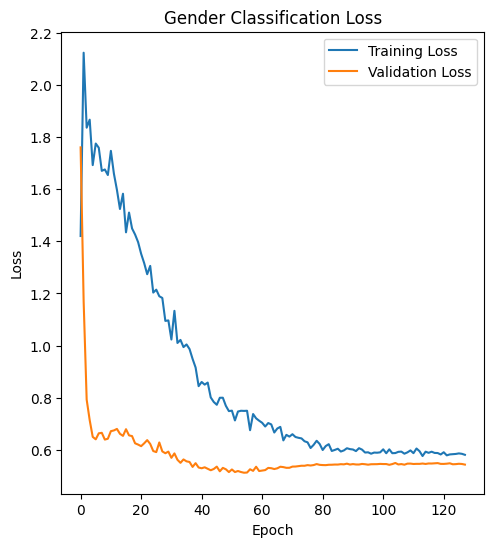

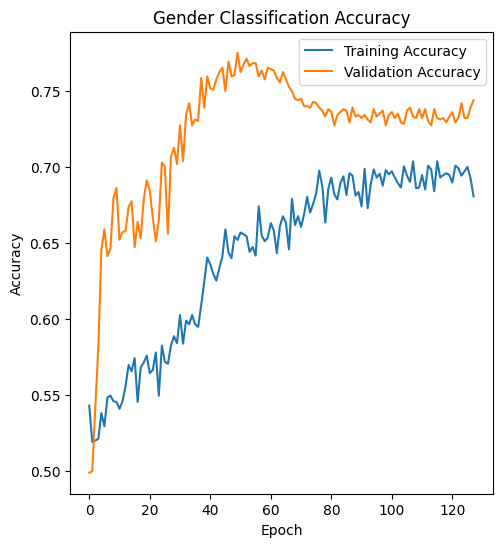

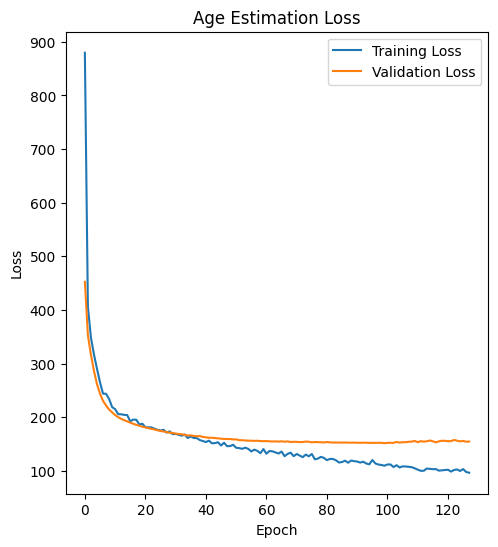

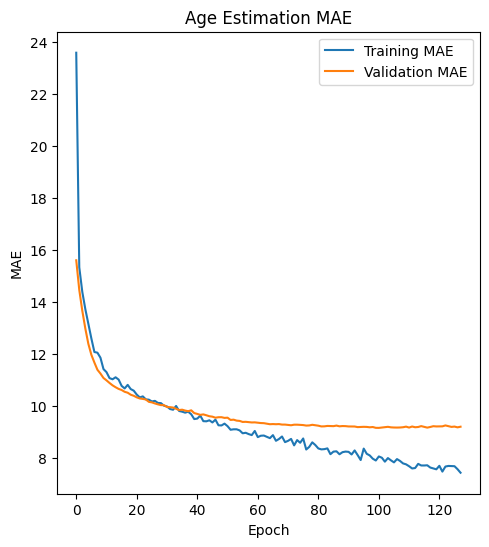

In [ ]:
#
# Add your code here
#
import matplotlib.pyplot as plt

#Loss and accuracy for gender
gender_loss = history.history['gender_output_loss']
val_gender_loss = history.history['val_gender_output_loss']
gender_acc = history.history['gender_output_accuracy']
val_gender_acc = history.history['val_gender_output_accuracy']

print(max(val_gender_acc))


#Loss and MAE for age
age_loss = history.history['age_output_loss']
val_age_loss = history.history['val_age_output_loss']
age_mae = history.history['age_output_mae']
val_age_mae = history.history['val_age_output_mae']

print(min(val_age_mae))

#Plot loss for gender
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gender_loss, label='Training Loss')
plt.plot(val_gender_loss, label='Validation Loss')
plt.title('Gender Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#Plot accuracy for
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(gender_acc, label='Training Accuracy')
plt.plot(val_gender_acc, label='Validation Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot loss for age
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(age_loss, label='Training Loss')
plt.plot(val_age_loss, label='Validation Loss')
plt.title('Age Estimation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot MAE for age
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(age_mae, label='Training MAE')
plt.plot(val_age_mae, label='Validation MAE')
plt.title('Age Estimation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#